In [1]:
#for i in *.jpeg; do newname="$(echo $i|cut -d. -f1)";mv $i $newname;done

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import itertools as it
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
PATH            = './data_reduced'
E_PATH          = './enc_params'
D_PATH          = './dec_params'
EPOCH           = 20
BATCH_SIZE      = 1
LR              = 0.0001
WORKERS         = 3
MIN             = 6.0e-10
MAX             = 1.0-6.0e-10
L               = 200
FO              = 24
FI              = 12
MIDDLE          = 50
ALPHA           = 0.9

In [4]:
class RNN_Loader(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir   = root_dir
        self.transform  = transform  
        self.n_images   = len(os.listdir(root_dir))
    def __len__(self):
            return self.n_images    
    def __getitem__(self, location):
        x_name    = self.root_dir + '/' + str(location)
        y_name    = self.root_dir + '/' + str(location+1)
        img_x     = io.imread(x_name)
        img_y     = io.imread(y_name)
        if self.transform:
            img_x = self.transform(img_x)
            img_y = self.transform(img_y)
        return (img_x,img_y)

tense        = transforms.ToTensor()
pil          = transforms.ToPILImage()
resize       = transforms.Resize((L,L))
grayscale    = transforms.Grayscale()
composed     = transforms.Compose([pil, resize, grayscale, tense])
        
rnn_set        = RNN_Loader(PATH, composed)
print(f'Number of images in the dataset is {len(rnn_set)}')

rnn_loader = DataLoader(dataset       =rnn_set,
                          batch_size  =1,
                          shuffle     =False,
                          num_workers =WORKERS)

Number of images in the dataset is 549


In [5]:
# Note: (N,Cin,Hin,Win)
# N: batch size of input. So 100 RGB 28X28 images is (100,3,100,100) 

class Enc(nn.Module):
    def __init__(self):
        super(Enc, self).__init__()

        self.E_cnnOuter = nn.Conv2d(in_channels=1,
                                out_channels=FO,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.E_bnOuter = nn.BatchNorm2d(FO)
        self.E_tOuter = nn.ELU(alpha=ALPHA)
        self.E_mpOuter = nn.MaxPool2d(2, 
                                    stride=2,
                                    padding=0,
                                    return_indices=True)
        
        self.E_cnnInner = nn.Conv2d(FO, FI,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1)
        self.E_bnInner = nn.BatchNorm2d(FI)
        self.E_tInner = nn.ELU(alpha=ALPHA)
        self.E_mpInner = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0,
                                    return_indices=True)
    def forward(self, input):
        x = self.E_cnnOuter(input)
        x = self.E_tOuter(x)
        x = self.E_bnOuter(x)
        x, o_index = self.E_mpOuter(x)
        
        x = self.E_cnnInner(x)
        x = self.E_tInner(x)
        x = self.E_bnInner(x)
        x, i_index = self.E_mpInner(x)
        
        return x, i_index, o_index


class Dec(nn.Module):
    def __init__(self):
        super(Dec, self).__init__()
        self.D_mpInner = nn.MaxUnpool2d(kernel_size=2,
                                         stride=2,
                                         padding=0)
        self.D_tInner   = nn.ELU(alpha=ALPHA) 
        self.D_bnInner = nn.BatchNorm2d(FI)
        self.D_cnnInner = nn.ConvTranspose2d(FI, FO,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1)
        self.D_mpOuter = nn.MaxUnpool2d(kernel_size=2,
                                        stride=2,
                                        padding=0)
        self.D_tOuter = nn.ELU(alpha=ALPHA)
        self.D_bnOuter = nn.BatchNorm2d(FO)
        self.D_cnnOuter = nn.ConvTranspose2d(FO, 1,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1)
        self.sig = nn.Sigmoid()
        
    
    def forward(self, input, i_index, o_index):
        x = self.D_mpInner(input, i_index)
        x = self.D_tInner(x)
        x = self.D_bnInner(x)
        x = self.D_cnnInner(x)
        x = self.D_mpOuter(x, o_index)
        x = self.D_tOuter(x)
        x = self.D_bnOuter(x)
        x = self.D_cnnOuter(x)
        
        x = self.sig(x)
        return x
# input (seq, batch, feature)   

class LS(nn.Module):
    def __init__(self):
        super(LS, self).__init__()
    
        self.lstm = nn.LSTM(input_size=MIDDLE**2,
                        hidden_size=MIDDLE**2)
        self.h = self.init_hidden()
    
    def init_hidden(self, h=None):
        if h == None:
            return (torch.zeros(1, FI, MIDDLE**2).cuda(),
                    torch.zeros(1, FI, MIDDLE**2).cuda())
        else:
            return (h[0].detach(), h[1].detach())
    
    
    def forward(self, input, h_in):
        out, h_out = self.lstm(input, h_in)
        return out, h_out
        

In [6]:
enc = Enc()
dec = Dec()
enc.load_state_dict(torch.load(E_PATH))
enc.cuda()
dec.load_state_dict(torch.load(D_PATH))
dec.cuda()
                              
#for param in enc.parameters():
#    param.requires_grad = False
#for param in dec.parameters():
#    param.requires_grad = False
    
ls = LS().cuda()

In [7]:
def sequence_evaluate(e, l, d, x, y):
    e.eval()
    l.eval()
    d.eval()
    h = l.init_hidden()
    with torch.no_grad():
        encoded, inner, outer = enc(x)
        pred, h  = ls(encoded.view(1,FI,-1), h)
        decoded  = dec(pred.view(1,FI,MIDDLE,MIDDLE), inner, outer)
        loss = loss_fn(decoded, y)
    e.train()
    l.train()
    d.train()
    
    return loss.item(), decoded, y

def show_image(x, y, count):
    print(f'Step {count}')
    plt.figure(figsize=(7,7))
    plt.subplot(131)
    orig_img = x.detach().cpu().numpy().reshape(L,L)
    plt.imshow(orig_img)
    plt.title('x')
    plt.axis('off')
    plt.subplot(132)
    recon_img = y.detach().cpu().numpy().reshape(L,L)
    plt.imshow(recon_img)
    plt.title('y')
    plt.axis('off')
    plt.subplot(133)
    diff = y-x
    diff_img = diff.detach().cpu().numpy().reshape(L,L)
    plt.imshow(diff_img)
    plt.title('diff')
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

Epoch 0 Context 1
Step 0


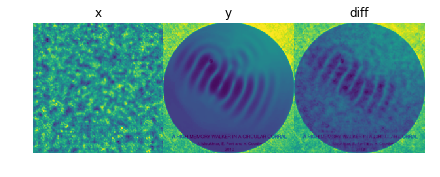

Step 1


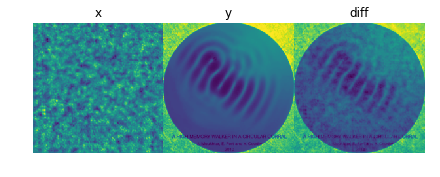

Epoch 1 Context 1
Epoch 2 Context 1
Epoch 3 Context 1
Epoch 4 Context 1
Epoch 5 Context 1
Epoch 6 Context 1
Epoch 7 Context 1
Epoch 8 Context 1
Epoch 9 Context 1
Epoch 10 Context 1
Epoch 11 Context 1
Epoch 12 Context 1
Epoch 13 Context 1
Epoch 14 Context 1
Epoch 15 Context 1
Epoch 16 Context 1
Epoch 17 Context 1
Epoch 18 Context 1
Epoch 19 Context 1
Epoch 0 Context 3
Epoch 1 Context 3
Epoch 2 Context 3
Epoch 3 Context 3
Epoch 4 Context 3
Epoch 5 Context 3
Epoch 6 Context 3
Epoch 7 Context 3
Epoch 8 Context 3
Epoch 9 Context 3
Epoch 10 Context 3
Epoch 11 Context 3
Epoch 12 Context 3
Epoch 13 Context 3
Epoch 14 Context 3
Epoch 15 Context 3
Epoch 16 Context 3
Epoch 17 Context 3
Epoch 18 Context 3
Epoch 19 Context 3
Epoch 0 Context 6
Epoch 1 Context 6
Epoch 2 Context 6
Epoch 3 Context 6
Epoch 4 Context 6
Epoch 5 Context 6
Epoch 6 Context 6
Epoch 7 Context 6
Epoch 8 Context 6
Epoch 9 Context 6
Epoch 10 Context 6
Epoch 11 Context 6
Epoch 12 Context 6
Epoch 13 Context 6
Epoch 14 Context 6
Epo

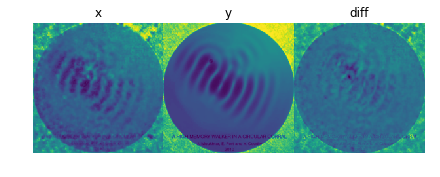

Step 1


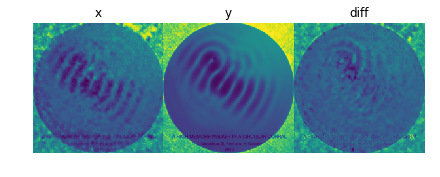

Step 2


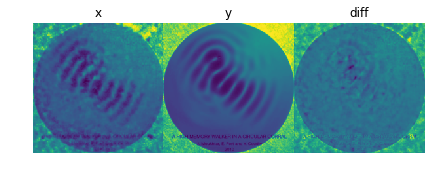

Step 3


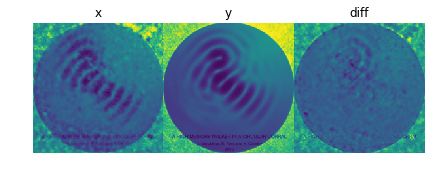

Step 4


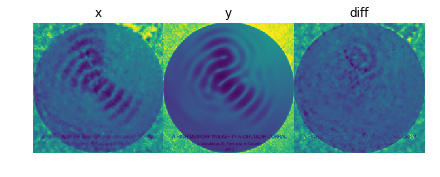

Step 5


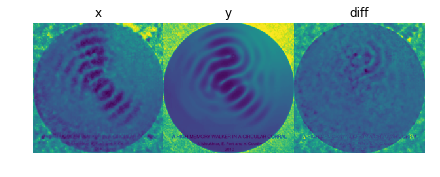

Step 6


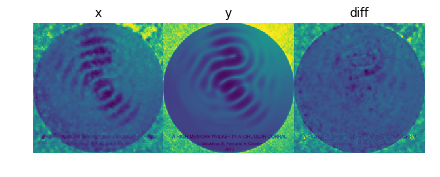

Step 7


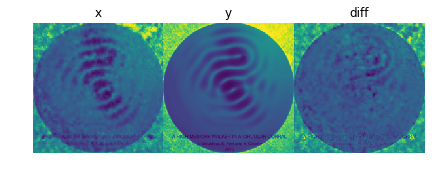

Step 8


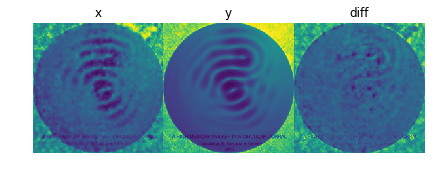

Step 9


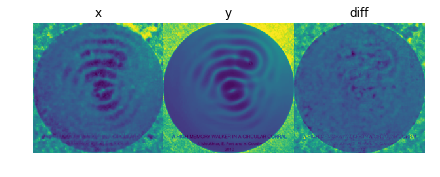

Step 10


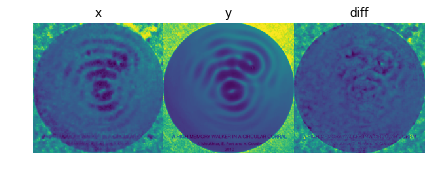

Epoch 1 Context 10
Epoch 2 Context 10
Epoch 3 Context 10
Epoch 4 Context 10
Epoch 5 Context 10
Epoch 6 Context 10
Epoch 7 Context 10
Epoch 8 Context 10
Epoch 9 Context 10
Epoch 10 Context 10
Epoch 11 Context 10
Epoch 12 Context 10
Epoch 13 Context 10
Epoch 14 Context 10
Epoch 15 Context 10
Epoch 16 Context 10
Epoch 17 Context 10
Epoch 18 Context 10
Epoch 19 Context 10


In [8]:
all_runs = []
#grads = []
CONTEXT_LENGTH = [1,3,6,10]
plt.ion()
chained = it.chain(enc.parameters(),
                       ls.parameters(),
                       dec.parameters())
optimizer = torch.optim.RMSprop(chained, lr=LR)
loss_fn = nn.MSELoss(reduction='mean')
loss_list = []
h = ls.init_hidden()
for context_length in CONTEXT_LENGTH:
    ls.train()
    seq_loss = 0.0
    loss_list = []
    valid_list = []
    for epoch in range(EPOCH):
        valid_loss = 0.0
        print(f'Epoch {epoch} Context {context_length}')
        for step, pair in enumerate(rnn_loader):
            if step == (len(rnn_set)-2): break
            enc.zero_grad()
            ls.zero_grad()
            dec.zero_grad()
            pattern = pair[0].cuda()
            label = pair[1].cuda()
            if (step <= context_length):
                if((epoch%50 == 0)&(context_length in [1, 10])):
                    v_loss, x, y = sequence_evaluate(enc,
                                                    ls,
                                                    dec,
                                                    pattern,
                                                    label)
                    valid_loss += v_loss
                    show_image(x, y, step)
                continue
            encoded, inner, outer = enc(pattern)
            pred, h  = ls(encoded.view(1,FI,-1), h)
            decoded  = dec(pred.view(1,FI,MIDDLE,MIDDLE), inner, outer)
            loss = loss_fn(decoded, label)

            if step%context_length == 0:
                h = ls.init_hidden(h)
                loss.backward()
                loss_list.append(loss.item())
                valid_list.append(valid_loss/float(context_length))
                optimizer.step()
    all_runs.append(loss_list)
plt.ioff()

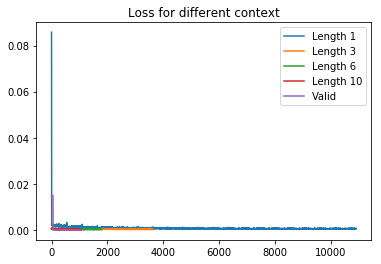

In [9]:
plt.figure()
for i in range(len(all_runs)):
    plt.plot(all_runs[i], label=f'Length {CONTEXT_LENGTH[i]}')
plt.plot(valid_list, label='Valid')
plt.title('Loss for different context')
plt.legend()
plt.show()

In [10]:
#PATH1 = './enc1_params'
#PATH2 = './dec1_params'
#PATH3 = './ls1_params'

#torch.save(enc.state_dict(), PATH1)
#torch.save(dec.state_dict(), PATH2)
#torch.save(ls.state_dict(), PATH2)